<a href="https://colab.research.google.com/github/JonathanKulpa/Motion-Artifact-Signal-Generation-Toolkit/blob/Branch1/MC_Train_and_Sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MC Training and Simulation**

This python notebook allows you to train a Markov Chain (MC) model using a sample motion artifact signal, and output a simulated motion artifact signal using the model.

You will need to have a sample file of motion artifact data so that the MC model can be trained.

If you plan on training the model and simulating a motion artifact signal from the model, run all the cells.

If you only plan on training the model, run the cells up until the beginning of Part 2.

If you plan on simulating a motion artifact signal using a model that was trained previously, run the following cell for loading the required libraries, and then continue running from Part 2.

In [ ]:
!pip install markovify
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.signal import butter, freqz
from scipy.fftpack import fft
import pandas as pd
import matplotlib.pylab as pylab
import string
import scipy.io
import math
from google.colab import files
import io
import markovify
import json
import csv

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 7.0 MB/s eta 0:00:00
  Created wheel for markovify: filename=markovify-0.9.4-py3-none-any.whl size=18607 sha256=236d179423e0438e516fdb0c7445f62daa270748796a9f61a09feb5edc78bf0f
  Stored in directory: /root/.cache/pip/wheels/ca/8c/c5/41413e24c484f883a100c63ca7b3b0362b7c6f6eb6d7c9cc7f
Successfully built markovify


# **Uploading Sample Signal and Preprocessing**

Load sample motion artifact and preprocessing

## Uploading Sample Motion Artifact Data
Choose the sample motion artifact data you would like to use to train the model. File must be in *.csv* format to upload.

There are two options to upload the file.

**Option 1: Upload directly from your PC**

Change the filename in the code to match the sample motion artifact data you would like to use to train the model. Once you run the code cell below, click on "*Choose Files*" and select the .csv file you would like to use.

In the cell below, change "*filename*" accordingly.

In [ ]:
uploaded  = files.upload()
data_save = pd.read_csv(io.BytesIO(uploaded['BR_S1_85_Ch1.csv']))

x= data_save["x"]
x = x.dropna()

Saving BR_S1_85_Ch1.csv to BR_S1_85_Ch1.csv


**Option 2: Upload from files saved on Google Drive**

Firstly, you will need to mount your Google Drive onto this Google Colab session.

This is done in the first code cell below. Upon running this cell you will be asked to sign into your Google account, from there you will need to copy a password and paste it back here in the Google Colab session. You will then be able to load and save files to your Google Drive directly from Google Colab.

In [ ]:
#Run this cell to mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Secondly, change the filename in the code below to match the sample motion artifact data you would like to use to train the model. You will also need to ensure the file path matches that of your file from your Google Drive.

In the cell below, change 'YOUR_FILE_NAME' and 'YOUR_FILE_PATH' accordingly.

In [ ]:
#Run this cell to download your specific filename
filename = "YOUR_FILE_NAME"
path = "/content/drive/My Drive/YOUR_FILE_PATH/{}.csv".format(filename)
data_save = pd.read_csv(path)

x= data_save["x"]
x = x.dropna()

## Preprocessing and Plotting

Adjust the sampling frequency by changing ***fs*** to match the sampling frequency of the input signal.

Text(0.5, 1.0, 'Input signal')

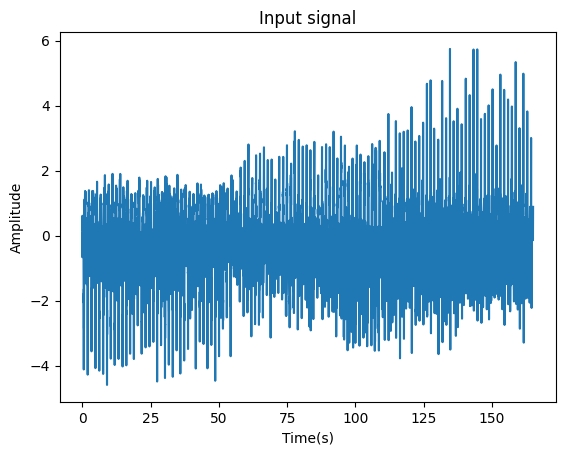

In [ ]:
fs = 2000
x = np.asarray(x)

lenx = np.size(x)
t_input = np.linspace(0, lenx/fs, lenx)

# Visualize the generated motion artifact signal over time
plt.plot(t_input, x)
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.title('Input signal')

###Lowpass Filter

In [ ]:
def butter_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data, axis=0)
    return y

In [ ]:
# Setting standard filter requirements.

# Specify the order of the lowpass filter
order = 6
# Specify the cutoff frequency for the lowpass filter
cutoff = 10

y = butter_lowpass_filter(x, cutoff, fs, order)

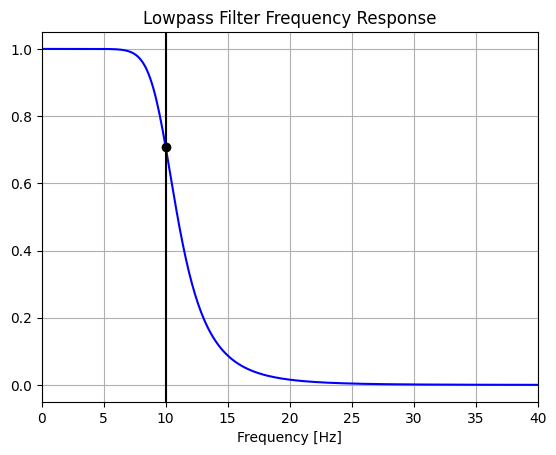

In [ ]:
b, a = butter_lowpass(cutoff, fs, order)

# Plotting the frequency response of the lowpass filter.
w, h = freqz(b, a, worN=8000)
#plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 40)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

###Power Normalization

In [ ]:
signal_power = np.sum(np.square(y))/len(y)
v = y/np.sqrt(signal_power)

### Downsample

Downsample the data by specifying your new sampling frequency of the output signal. The new sampling frequency is denoted by ***new_fs***.

In [ ]:
new_fs = 67 # New sampling frequency in Hz
df = fs/new_fs
z = signal.resample(v, np.int(len(v)/df))

<ipython-input-8-a7e388ea1e5f>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = signal.resample(v, np.int(len(v)/df))


###Plot Preprocessed Signal

In [ ]:
def find_psd(z, new_fs):
    f, Pxx_den = signal.welch(z, fs = new_fs, nperseg = len(z)/5)
    return(Pxx_den,f)

pxx, f = find_psd(z, new_fs)

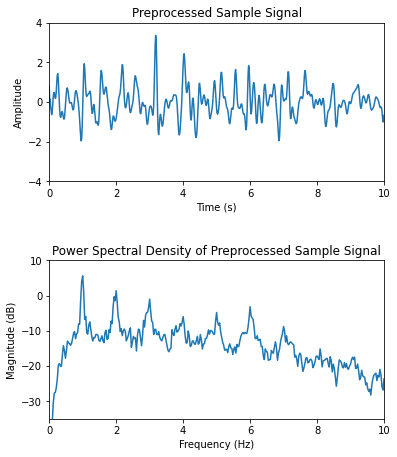

In [ ]:
#Plot preprocessed signal
length_z = np.size(z)
t_processed = np.linspace(0, length_z/new_fs, length_z)
#Preprocessed signal
plt.subplot(2,1,1)
plt.plot(t_processed, z)
plt.xlim([0,10]) #Set time values to zoom on a part of the input signal (seconds)
plt.ylim([-4,4]) #Adjust amplitude values for better viewing
plt.title('Preprocessed Sample Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')

#Plot low pass filtered and power normalized signal
#ORIGINAL SIGNAL
plt.subplot(2,1,2)
plt.plot(f, 10*np.log10(pxx))
plt.xlim([0,10]) #Frequency values (Hz) can be adjusted for better viewing
plt.ylim([-35,10]) #Magnitude values (dB) can be adjusted for better viewing
plt.title('Power Spectral Density of Preprocessed Sample Signal')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.5, wspace=None, hspace=0.5)

# **Part 1: Training**

## MC model training

**markovprocess** trains the MC model based on the uploaded signal.

Returns parameters of the trained MC model.

In [ ]:
"""MC generation function"""
def markovprocess(x,S_d=32):
  x_max = np.max(x)
  x_min = np.min(x)
  xd = x
  data = np.round((xd-x_min)/(x_max-x_min)*(S_d-1))

  x_q = np.reshape(data,-1)
  numUniqueCharacters = int(max(x_q))+1
  #build a dictionary
  A = string.ascii_lowercase
  number = int(np.ceil(math.log(numUniqueCharacters, 26)))

  dictionary_place = ["" for i in range(numUniqueCharacters)]
  n = 0
  count = 0
  for i in range (numUniqueCharacters):
      dictionary_place[i] = A[count] + A[n]
      count = count + 1
      if i % 26 == 0:
          n = n+1
          count = 0

  #map numbers onto this dictionary
  sequence = ''
  for i in range(x_q.size) :
    test = dictionary_place[int(x_q[i])]
    sequence += (" " + test + ' ')

  length_x_q = len(x_q)
  data_parameters = [fs, new_fs, numUniqueCharacters, length_x_q, x_max, x_min]
  text_model = markovify.Text(sequence, state_size=16, retain_original=False)
  print(type(text_model))
  model_json = text_model.to_json()
  print(type(model_json))
  with open('text_model.json', 'w') as outfile:
    outfile.write(model_json)
  return text_model, dictionary_place, data_parameters

text_model, dictionary_place, data_parameters = markovprocess(z,S_d = 32)

sequence is:  qb  qb  pb  ob  pb  qb  rb  sb  sb  sb  sb  sb  sb  sb  sb  sb  sb  sb  rb  sb  sb  sb  sb  sb  sb  sb  sb  sb  sb  rb  pb  ob  nb  nb  nb  mb  jb  gb  eb  eb  fb  gb  hb  gb  fb  eb  gb  jb  nb  qb  tb  ub  ub  tb  tb  ub  ub  vb  vb  vb  vb  ub  ub  ub  ub  vb  vb  wb  wb  wb  wb  wb  vb  vb  vb  vb  wb  wb  wb  vb  vb  ub  tb  sb  rb  qb  qb  pb  pb  ob  mb  lb  lb  lb  nb  ob  pb  qb  qb  qb  qb  qb  pb  pb  pb  qb  rb  rb  sb  tb  tb  sb  sb  rb  rb  rb  rb  sb  sb  sb  sb  sb  sb  sb  sb  rb  pb  ob  mb  lb  jb  hb  fb  db  cb  cb  fb  hb  jb  kb  lb  lb  mb  ob  rb  sb  tb  ub  tb  tb  ub  ub  vb  vb  vb  vb  vb  vb  ub  ub  vb  vb  wb  wb  wb  wb  vb  vb  ub  ub  ub  ub  vb  vb  vb  ub  sb  qb  ob  mb  nb  nb  ob  pb  ob  nb  mb  mb  mb  ob  pb  pb  pb  ob  ob  ob  pb  qb  qb  qb  pb  pb  qb  rb  rb  sb  sb  tb  tb  tb  tb  tb  tb  tb  tb  tb  tb  tb  sb  sb  rb  pb  ob  nb  mb  kb  ib  gb  fb  fb  gb  hb  hb  gb  eb  fb  hb  lb  pb  tb  vb  wb  vb  vb  vb  vb  wb

## Save the model parameters

*Optional:* Run this cell if you would like to save the model to be able to generate a signal at another time.

Once the cell below is run, you must save the *text_model.json*, *dictionary_place.csv* and *data_parameters.csv* files. Simply run the next code cell to save the files to your local drive.

In [ ]:
dfparameter = pd.DataFrame(dictionary_place)
dfparameter.to_csv("dictionary_place.csv")

data_parameters = [fs, new_fs, numUniqueCharacters, length_x_q, x_max, x_min]
dfparameter3 = pd.DataFrame(data_parameters)
dfparameter3.to_csv("data_parameters.csv")

In [ ]:
#Download the files
files.download('dictionary_place.csv')
files.download('text_model.json')
files.download('data_parameters.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**Part 2: Simulation**


## Load model parameters from a previously trained MC model

Once the cell below is run, click '*Choose Files*' and select the ***dictionary_place.csv*** file, followed by the ***text_model.json*** file, and lastly, the ***data_parameters.csv*** file.  

**If you have just trained a model, you may skip the code cell below.**

In [ ]:
uploaded_var = files.upload()
dictionary_place_csv = pd.read_csv("dictionary_place.csv")
dictionary_place = dictionary_place_csv['0'].tolist()

uploaded_text_model = files.upload()

uploaded_data_parameters = files.upload()
data_parameters = pd.read_csv("data_parameters.csv",index_col=0)
fs = data_parameters.iloc[0,0]

Saving dictionary_place.csv to dictionary_place.csv


Saving text_model.json to text_model.json


Saving data_parameters.csv to data_parameters.csv


## Markov Chain Simulation
**MCgenerate** simulates a motion artifact using the trained model.

S_d is the quantization.
state_size is a key parameter that can be changed.

Returns the simulated data.

In [ ]:
"""MC generation function"""
def MCgenerate(dictionary_place, data_parameters, length_x_q, S_d):
  with open('text_model.json', 'r') as openfile:
      model_json = json.load(openfile)
      model_json2 = json.dumps(model_json)


  reconstituted_model = markovify.Text.from_json(model_json2)
  x_max = data_parameters.iloc[4,0]
  x_min = data_parameters.iloc[5,0]

  numUniqueCharacters = data_parameters.iloc[2,0]

  length_test = 0
  while length_test<11000:
      output = reconstituted_model.make_short_sentence(max_chars = 100000, min_chars=10000)
      length_test = len(output)
  output_q = np.zeros((int((len(output)-1)/3),1))
  count = 0
  for i in np.arange(0,len(output)-3,3):
      tester = output[i:i+2]
      num_dic = dictionary_place.index(tester)
      output_q[count] = num_dic
      count = count +1

  output_q = output_q[0:(int(data_parameters.iloc[3,0]))]
  down_factor = (data_parameters.iloc[0,0])/(data_parameters.iloc[1,0])
  MCdataup = signal.resample(output_q, np.int(len(output_q)*down_factor))
  MCdatascale = (MCdataup/(S_d-1)*(x_max-x_min))+x_min
  MCdatascale = MCdatascale[20000:]
  MCdatascale = np.reshape(MCdatascale,-1)
  return MCdatascale

dataMC = MCgenerate(dictionary_place, data_parameters, S_d=64)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


## Visualize Simulated Motion Artifact

The cells below will allow you to view the output signal in the time domain as well as the power spectral density (PSD).

In [ ]:
def find_psd_out(x, fs):
    f, Pxx_den = signal.welch(x, fs = fs, nperseg = len(x)/5)
    return(Pxx_den,f)

pxx_output, f_output = find_psd_out(dataMC, fs)

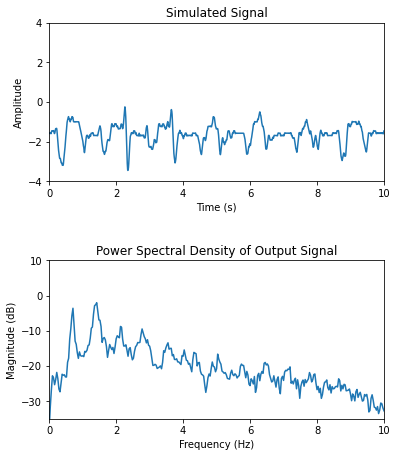

In [ ]:
#Plot generated signal
length_output = np.size(dataMC)
t_output = np.linspace(0, length_output/fs, length_output)
#Generated signal
plt.subplot(2,1,1)
plt.plot(t_output, dataMC)
plt.xlim([0,10]) #Set time values to zoom on a part of the input signal (seconds)
plt.ylim([-4,4]) #Adjust amplitude values for better viewing
plt.title('Simulated Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')

#Plot PSD plot of output signal
plt.subplot(2,1,2)
plt.plot(f_output, 10*np.log10(pxx_output))
plt.xlim([0,10]) #Frequency values (Hz) can be adjusted for better viewing
plt.ylim([-35,10]) #Magnitude values (dB) can be adjusted for better viewing
plt.title('Power Spectral Density of Output Signal')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.5, wspace=None, hspace=0.5)

## Save the Generated Motion Artifact Data

The simulated motion artifact signal can be saved in one of two ways.

**Option 1: Save simulated motion artifact data directly to computer**

In the cell below, change "*generated_signal*" to what you would like the file to be called. The file will be saved in *.csv* format.

In [ ]:
df = pd.DataFrame(dataMC)
df.to_csv("generated_signal.csv")
files.download('generated_signal.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Option 2: Save simulated motion artifact data to a file on Google Drive**

Change the filename to what you would like to save the file as. You will also need to change the file path to adjust where the file is saved within your Google Drive. If you have not yet done so, ensure your Google Drive is mounted onto this notebook as seen in the first cell of "Option 2" of "Uploading Sample Motion Artifact Data". The file will be saved in *.csv* format.

In the cell below, change 'NEW_FILE_NAME' and 'NEW_FILE_PATH' accordingly.

In [ ]:
df = pd.DataFrame(dataMC)
filename = "NEW_FILE_NAME"
df.to_csv("/content/drive/My Drive/NEW_FILE_PATH/{}.csv".format(filename))